In [1]:
import os
import re
import string

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nltk

import itertools
from collections import Counter
from nltk.corpus import stopwords
from pymystem3 import Mystem
from nltk.stem.snowball import SnowballStemmer

from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

from sklearn.metrics import accuracy_score
from sklearn.metrics import log_loss
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

import warnings
warnings.filterwarnings('ignore')

## Получение данных

In [2]:
# считываем данные с сохраненных веб-страниц

def reading_group(html, label):

    with open(html) as f:
        page = f.read()

    author, date, text = [], [], []

    comments = re.findall(r'<div class="bp_post clear_fix "((.|\n)*?)Показать список оценивших', page)
    for comment in comments:
        comment = comment[0]
        author.append(re.search(r'<a class="bp_author"(.*)">(.*)</a>', comment)[2])
        date.append(re.search(r'<a class="bp_date"(.*)">(.*)</a>', comment)[2])
        try:
            text.append(re.search(r'<div class="bp_text">(.*)</div>', comment)[1])
        except:
            text.append('')

    t_c, h_c, p_c = [], [], []

    for comment in text:
        href = re.findall(r"^<a href(.*)mem_link(.*)(.*)</a>", comment)
        
        ret = 'return showPhoto' in comment
        p_c.append(ret)
        
        if href:        
            h_lst = []
            for n in href:
                href = re.findall(r'Board.mentionOver\(this\)">(.*)', n[1])
                h_lst.append(href)
            comment = "{}, {}".format(','.join(h_lst[0]), comment.split("</a>,")[1])
            h_c.append(h_lst[0])
        else:
            h_c.append("na")
        t_c.append(re.sub('<br><br>', '', re.sub('</?div(.*)>', '', comment)))

    comments = pd.DataFrame(list(zip(author, date, t_c, h_c, p_c)),
                            columns=['author', 'date', 'comment', 'mention', 'image'])
    
    if label:
        comments['is_fake'] = 0
    else:
        comments['is_fake'] = 1
    
    return comments

In [3]:
# создаем датафрейм с данными каждой из подпапок

def create_df(directory, label):
    df = pd.DataFrame()
    path = './html/' + directory
    for filename in os.listdir(path):
        if filename.endswith(".html"):
            comments = reading_group(path + '/' + filename, label)
            df = pd.concat([df, comments], sort=True, ignore_index=True)
        else:
            continue
    return df

**author** - the user that posted a comment<br>
**comment** - text of the review<br>
**date** - when a comment was created<br>
**image** - True (1) if photos are attached, false otherwise<br>
**mention** - True (1) if there is a mention at the start of the message of another user, false otherwise<br>
**is_fake** - target label, True (1) if a comment is fake, false otherwise

In [4]:
# подпапка с реальными отзывами

df_true = create_df('vk/true', True)
df_true.tail()

,author,comment,date,image,is_fake,mention
2067,Евгений Беляев,"Заказывал Yezzy bost v2, шли долго из за каран...",28 апр 2020 в 19:09,True,0,na
2068,Андрей Ярилов,Доброго времени суток!) Заказал Yeezy 350 v2 y...,28 апр 2020 в 20:55,False,0,na
2069,Андрей Белый,"Заказывал вчера, доставили сегодня. Спасибо бо...",29 апр 2020 в 22:35,True,0,na
2070,Екатерина Самылина,"Качественная сумка,обязательно буду заказывать...",вчера в 14:56,True,0,na
2071,Никита Добрынин,"Заказывал штаны Aape и лонгслив Heron Preston,...",вчера в 15:00,True,0,na


In [5]:
# подпапка с фальшивыми отзывами

df_false = create_df('vk/false', False)
df_false.tail()

,author,comment,date,image,is_fake,mention
617,Вика Сергеева,"Получила свои вещи, бомбер и платье безумно ра...",30 апр 2018 в 18:34,False,1,na
618,Олександра Аравіцька,"Спасибо!!!!Очень быстро и никаких проблем, даж...",1 мая 2018 в 8:32,False,1,na
619,Олеся Фирсова,"Спасибо большое , получила платьице, цвет как ...",7 мая 2018 в 12:55,True,1,na
620,Анастасия Нестерова,Сегодня доставили мне мои шлёпки и джинсы. К к...,8 мая 2018 в 15:06,False,1,na
621,Наталья Белоусова,"Такой шикарный магазин и так мало отзывов ,это...",сегодня в 14:37,False,1,na


In [6]:
# объединяем датафреймы

df = pd.concat([df_false, df_true], sort=True, ignore_index=True)
df

,author,comment,date,image,is_fake,mention
0,Магазин кроссовок / Sniiiky,Тема только для отзывов! За отзыв с фото вы по...,21 сен 2017 в 2:16,False,1,na
1,Анна Токарева,"Сегодня забрала на почте! Качество отличное, у...",25 ноя 2017 в 6:46,True,1,na
2,Магазин кроссовок / Sniiiky,"Анна, спасибо! <img class=""emoji_css"" alt=""&#...",25 ноя 2017 в 9:04,False,1,[Анна]
3,Анна Николаева,"Вчера получила, до сих пор не нарадуюсь и про ...",27 ноя 2017 в 16:20,True,1,na
4,Магазин кроссовок / Sniiiky,"Анна, спасибо! <img class=""emoji_css"" alt=""&#...",27 ноя 2017 в 19:22,False,1,[Анна]
...,...,...,...,...,...,...
2689,Евгений Беляев,"Заказывал Yezzy bost v2, шли долго из за каран...",28 апр 2020 в 19:09,True,0,na
2690,Андрей Ярилов,Доброго времени суток!) Заказал Yeezy 350 v2 y...,28 апр 2020 в 20:55,False,0,na
2691,Андрей Белый,"Заказывал вчера, доставили сегодня. Спасибо бо...",29 апр 2020 в 22:35,True,0,na
2692,Екатерина Самылина,"Качественная сумка,обязательно буду заказывать...",вчера в 14:56,True,0,na


In [7]:
# сохраняем результат в отдельный файл

df.to_csv('raw.csv', encoding='utf-8-sig')

## Предобработка данных

In [8]:
# удаляем комментарии владельцев групп

owners = ['BERISHMOT Store', 'Андрей Северец', 'Магазин кроссовок / Sniiiky',
          'Настя Осипова', '|Мобильные телефоны|', 'RUDI ROYALE', 'NICE DEVISE | Москва',
          'Lovely Shop - магазин женской одежды', 'Non S7op Shop (Nike~Reebok~Adidas~Asics)',
          'Модная женская одежда "Valum"', "Lady's Shop - магазин шикарной одежды"]

for i in owners:
    df = df[df.author != i]

In [9]:
df.shape

(2151, 6)

In [10]:
# удаляем из текстов теги и гиперссылки

def clean_str(string):
    """
    String cleaning: return only words
    """
    string = re.sub('<.*?>', ' ', string)
    string = re.sub(r"\s{2,}", " ", string)
    return string

df['comment'] = df['comment'].apply(clean_str)

In [11]:
# удаляем сообщения с упоминанием пользователей
# чаще всего это вопросы или ответы, а не отзывы

df = df[df.mention == 'na']
df = df.reset_index().drop(['mention', 'index'], axis=1)

In [12]:
indxs = df[df.comment.str.contains("\?", na=False)].index

In [13]:
df.shape

(1776, 5)

In [14]:
df = df.drop(df.index[indxs])

In [15]:
# удаляем вхождения с вопросами 

df = df.drop(df.columns[[0]], axis=1)

df.to_csv('out.csv', encoding='utf-8-sig')

In [16]:
df.shape

(1644, 4)

In [17]:
df.head(3)

,comment,date,image,is_fake
0,"Сегодня забрала на почте! Качество отличное, у...",25 ноя 2017 в 6:46,True,1
1,"Вчера получила, до сих пор не нарадуюсь и про ...",27 ноя 2017 в 16:20,True,1
2,Спасибо большое Всё отлично! Очень нравится,28 ноя 2017 в 14:07,True,1


# Исследование данных

Количество реальных и фейковых отзывов в корпусе:

In [18]:
df['is_fake'].value_counts()

0    1192
1     452
Name: is_fake, dtype: int64

Доля реальных комментариев в корпусе:

In [19]:
res = 1324 / (1324 + 452)
round(res, 3)

0.745

Количество отзывов с приклеплёнными фотографиями:

In [20]:
df['image'].value_counts()

True     1275
False     369
Name: image, dtype: int64

Часть отзывов с фото для фэйковых отзывов:

In [21]:
round(len(df[(df.image==True) & (df.is_fake==1)]) / len(df[df.is_fake==1]), 3)

0.695

Часть отзывов с фото для реальных отзывов:

In [22]:
round(len(df[(df.image==True) & (df.is_fake==0)]) / len(df[df.is_fake==0]), 3)

0.806

Добавим некоторые данные:

In [23]:
df_add = df.copy()

df_add['count_words'] = df["comment"].apply(lambda x: len(str(x).split()))
df_add['count_unique_words'] = df["comment"].apply(lambda x: len(set(str(x).split())))
df_add['count_letters'] = df["comment"].apply(lambda x: len(str(x)))
df_add["count_punctuations"] = df["comment"].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))
df_add["count_words_upper"] = df["comment"].apply(lambda x: len([w for w in str(x).split() if w.isupper()]))
df_add["count_words_title"] = df["comment"].apply(lambda x: len([w for w in str(x).split() if w.istitle()]))

In [24]:
df_add.tail()

,comment,date,image,is_fake,count_words,count_unique_words,count_letters,count_punctuations,count_words_upper,count_words_title
1771,"Заказывал Yezzy bost v2, шли долго из за каран...",28 апр 2020 в 19:09,True,0,21,21,132,4,0,3
1772,Доброго времени суток!) Заказал Yeezy 350 v2 y...,28 апр 2020 в 20:55,False,0,36,36,230,11,0,6
1773,"Заказывал вчера, доставили сегодня. Спасибо бо...",29 апр 2020 в 22:35,True,0,18,17,125,4,0,3
1774,"Качественная сумка,обязательно буду заказывать...",вчера в 14:56,True,0,6,6,62,3,0,1
1775,"Заказывал штаны Aape и лонгслив Heron Preston,...",вчера в 15:00,True,0,15,15,111,7,0,4


In [25]:
df_add.columns

Index(['comment', 'date', 'image', 'is_fake', 'count_words',
       'count_unique_words', 'count_letters', 'count_punctuations',
       'count_words_upper', 'count_words_title'],
      dtype='object')

In [26]:
print("Среднее число слов в фейковых отзывах: {}".
      format(round(df_add[df_add.is_fake == True].count_words.mean(), 3)))
print("Среднее число слов в реальных отзывах: {}".
      format(round(df_add[df_add.is_fake == False].count_words.mean(), 3)))

Среднее число слов в фейковых отзывах: 20.332
Среднее число слов в реальных отзывах: 23.014


In [27]:
print("Среднее число уникальных слов в фейковых отзывах: {}".
      format(round(df_add[df_add.is_fake == True].count_unique_words.mean(), 3)))
print("Среднее число уникальных слов в реальных отзывах: {}".
      format(round(df_add[df_add.is_fake == False].count_unique_words.mean(), 3)))

Среднее число уникальных слов в фейковых отзывах: 19.314
Среднее число уникальных слов в реальных отзывах: 21.369


In [28]:
print("Среднее число символов в фейковых отзывах: {}".
      format(round(df_add[df_add.is_fake == True].count_letters.mean(), 3)))
print("Среднее число символов в реальных отзывах: {}".
      format(round(df_add[df_add.is_fake == False].count_letters.mean(), 3)))

Среднее число символов в фейковых отзывах: 141.219
Среднее число символов в реальных отзывах: 152.594


In [29]:
print("Среднее число знаков пунктуации в фейковых отзывах: {}".
      format(round(df_add[df_add.is_fake == True].count_punctuations.mean(), 3)))
print("Среднее число знаков пунктуации в реальных отзывах: {}".
      format(round(df_add[df_add.is_fake == False].count_punctuations.mean(), 3)))

Среднее число знаков пунктуации в фейковых отзывах: 6.814
Среднее число знаков пунктуации в реальных отзывах: 6.219


In [30]:
print("Среднее число слов в верхнем регистре в фейковых отзывах: {}".
      format(round(df_add[df_add.is_fake == True].count_words_upper.mean(), 3)))
print("Среднее число слов в верхнем регистре в реальных отзывах: {}".
      format(round(df_add[df_add.is_fake == False].count_words_upper.mean(), 3)))

Среднее число слов в верхнем регистре в фейковых отзывах: 0.219
Среднее число слов в верхнем регистре в реальных отзывах: 0.404


In [31]:
print("Среднее число слов, написанных с заглавной буквы, в фейковых отзывах: {}".
      format(round(df_add[df_add.is_fake == True].count_words_title.mean(), 3)))
print("Среднее число слов, написанных с заглавной буквы, в реальных отзывах: {}".
      format(round(df_add[df_add.is_fake == False].count_words_title.mean(), 3)))

Среднее число слов, написанных с заглавной буквы, в фейковых отзывах: 2.482
Среднее число слов, написанных с заглавной буквы, в реальных отзывах: 3.646


## Tokenizing words

In [32]:
# составим список, включающий в себя все уникальные слова корпуса
# лемматизируем слова

vocabulary = []
numWords = []
lemmatized_texts = []

def text_lemmatize(text):
    global vocabulary 
    global numWords
    try:
        text = re.sub(r"[^А-Яа-яё]", " ", text).strip()
        ps = Mystem()
        text = ps.lemmatize(text)
        lemmatized_texts.append(text)
        vocabulary.extend(text)
        numWords.append(len(text))
        return ' '.join(text)
    except:
        lemmatized_texts.append('')
        return ''

In [33]:
df_lem = df.copy()
df_lem['comment'] = df_lem['comment'].apply(text_lemmatize)

vocabulary = list(set(vocabulary))

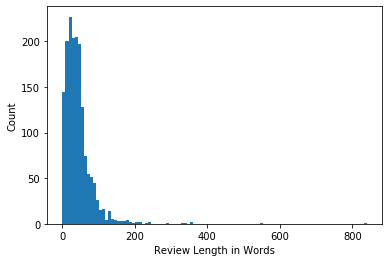

In [34]:
plt.hist(numWords, 100)
plt.xlabel('Review Length in Words')
plt.ylabel('Count')
plt.show()

In [35]:
print('Всего отзывов: ', len(numWords))
print('Всего слов: ', sum(numWords))
print('Всего уникальных слов: ', len(vocabulary))
print('Средняя длина отзыва в словах: ', sum(numWords)/len(numWords))

Всего отзывов:  1644
Всего слов:  70866
Всего уникальных слов:  2704
Средняя длина отзыва в словах:  43.105839416058394


In [36]:
df_lem['lemmas'] = lemmatized_texts
df_lem

,comment,date,image,is_fake,lemmas
0,сегодня забирать на почта качество ...,25 ноя 2017 в 6:46,True,1,"[сегодня, , забирать, , на, , почта, , ка..."
1,вчера получать до сей пора не нар...,27 ноя 2017 в 16:20,True,1,"[вчера, , получать, , до, , сей, , пора, ..."
2,спасибо большой все отличный очень ...,28 ноя 2017 в 14:07,True,1,"[спасибо, , большой, , все, , отличный, ,..."
3,спасибо за офигенный кросс \n,1 дек 2017 в 20:55,True,1,"[спасибо, , за, , офигенный, , кросс, \n]"
4,все получать переживать за качество ...,2 дек 2017 в 17:22,True,1,"[все, , получать, , переживать, , за, , к..."
...,...,...,...,...,...
1771,заказывать идти долго из ...,28 апр 2020 в 19:09,True,0,"[заказывать, , идти, , долго,..."
1772,добрый время сутки заказывать ...,28 апр 2020 в 20:55,False,0,"[добрый, , время, , сутки, , заказывать, ..."
1773,заказывать вчера доставлять сегодня ...,29 апр 2020 в 22:35,True,0,"[заказывать, , вчера, , доставлять, , сего..."
1774,качественный сумка обязательно быть за...,вчера в 14:56,True,0,"[качественный, , сумка, , обязательно, , бы..."


In [37]:
# удалим пустые леммы

clean_lemmas = []
regex = re.compile(r'\s+')

for text in lemmatized_texts:
    clean_lemmas.append([i for i in text if not regex.search(i)])

df_lem['lemmas'] = clean_lemmas

In [38]:
# делаем стемминг лемм

stemmer = SnowballStemmer("russian", ignore_stopwords=True)
stems = []

for i in df_lem.lemmas:
    row = []
    for n in i:
        row.append(stemmer.stem(n))
    stems.append(row)    

In [39]:
df_lem['stem'] = stems
df_lem.head(3)

,comment,date,image,is_fake,lemmas,stem
0,сегодня забирать на почта качество ...,25 ноя 2017 в 6:46,True,1,"[сегодня, забирать, на, почта, качество, отлич...","[сегодн, забира, на, почт, качеств, отличн, уп..."
1,вчера получать до сей пора не нар...,27 ноя 2017 в 16:20,True,1,"[вчера, получать, до, сей, пора, не, нарадоват...","[вчер, получа, до, се, пор, не, нарадова, и, п..."
2,спасибо большой все отличный очень ...,28 ноя 2017 в 14:07,True,1,"[спасибо, большой, все, отличный, очень, нрави...","[спасиб, больш, все, отличн, очен, нрав]"


In [40]:
# узнаем число уникальных стемм

vocabulary_stem = list(itertools.chain.from_iterable([i for i in df_lem['stem']]))
len(set(vocabulary_stem))

2413

In [41]:
df_lem.to_csv('out_bow.csv', encoding='utf-8-sig')

# Мешок слов

In [42]:
# создадим список лемм фейковых отзывов
bagOfFake = list(itertools.chain.from_iterable([i for i in df_lem.lemmas[df.is_fake == 1]]))

# создадим список лемм реальных отзывов
bagOfReal = list(itertools.chain.from_iterable([i for i in df_lem.lemmas[df.is_fake == 0]]))

# создадим список лемм всех отзывов
bagOfAll = bagOfFake + bagOfReal

In [43]:
# Формируем для каждого документа словарь в котором ключ - это слово, 
# а значение его частота в документе

from nltk.corpus import stopwords
stop_words = set(stopwords.words("russian"))

mapOfWordsFake = dict.fromkeys(vocabulary, 0)
mapOfWordsReal = dict.fromkeys(vocabulary, 0)
mapOfAllWords = dict.fromkeys(vocabulary, 0)

for word in bagOfFake:
    if word not in stop_words:
        mapOfWordsFake[word] += 1
for word in bagOfReal:
    if word not in stop_words:
        mapOfWordsReal[word] += 1
for word in bagOfAll:
    if word not in stop_words:
        mapOfAllWords[word] += 1

In [44]:
from wordcloud import WordCloud

def word_cloud(list, file):
    cloud = WordCloud(background_color="white", max_words=100)
    cloud.generate(' '.join(list))
    plt.imshow(cloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()
    cloud.to_file(file)

In [45]:
# функция выводит топ-100 слов для словаря

def maj_words(d):
    big_pos = []
    counter = 0
    for w in sorted(d, key=d.get, reverse=True)[:100]:
        big_pos.append(w)
        if counter < 20:
            print(w, d[w])
            counter +=  1
    return big_pos

In [46]:
mpn = maj_words(mapOfWordsReal)

заказывать 912
качество 701
спасибо 627
приходить 532
виктор 420
очень 402
размер 358
весь 266
день 260
хороший 213
носок 210
магазин 210
подарок 199
доставка 192
кроссовок 189
отличный 185
довольный 185
это 170
продавец 168
подходить 159


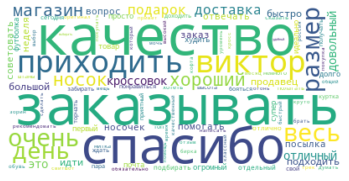

In [47]:
word_cloud(mpn, 'mpn.jpg')

Вхождение в топ слова "Виктор" объясняется тем, что это имена владельца одного из рассмотренных пабликов. Многие пользователи благодарят его в своих отзывах.

In [48]:
mpp = maj_words(mapOfWordsFake)

спасибо 281
очень 210
качество 164
заказывать 158
хороший 102
получать 98
довольный 96
большой 90
доставка 86
размер 86
приходить 79
платье 79
заказ 78
весь 68
магазин 61
подходить 55
отличный 54
свой 48
быстрый 47
быстро 47


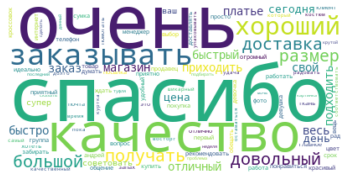

In [49]:
word_cloud(mpp, 'mpp.jpg')

Общих слов в топах mapOfWordsFake и mapOfWordsReal:

In [50]:
common_items = list((Counter(mpp) & Counter(mpn)).elements())
len(common_items)

57

In [51]:
mpa = maj_words(mapOfAllWords)

заказывать 1070
спасибо 908
качество 865
очень 612
приходить 611
размер 444
виктор 420
весь 334
хороший 315
день 304
довольный 281
доставка 278
магазин 271
отличный 239
большой 233
подходить 214
носок 212
подарок 208
это 207
кроссовок 207


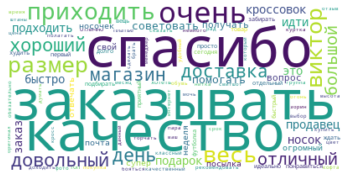

In [52]:
word_cloud(mpa, 'maj.jpg')

In [53]:
word_vectorizer = TfidfVectorizer(max_features=250000,  
                                  stop_words=stop_words,
                                  analyzer='word',
                                  ngram_range=(1,2))

Топ-10 слов по TF-IDF:

In [54]:
# только реальные отзывы

TFIDF = word_vectorizer.fit_transform(bagOfFake)
indices = np.argsort(word_vectorizer.idf_)[::-1]
features = word_vectorizer.get_feature_names()
top_n = 10
top_features = [features[i] for i in indices[:top_n]]
top_features

['реальный',
 'роооозовой',
 'принцепа',
 'мупер',
 'принимать',
 'мучительный',
 'мысль',
 'прикреплять',
 'прикольно',
 'прийшов']

In [55]:
# только фейковые отзывы

TFIDF = word_vectorizer.fit_transform(bagOfReal)
indices = np.argsort(word_vectorizer.idf_)[::-1]
features = word_vectorizer.get_feature_names()
top_n = 10
top_features = [features[i] for i in indices[:top_n]]
top_features

['ясно',
 'нк',
 'нервничать',
 'нереальный',
 'несоответствие',
 'нидавно',
 'ниже',
 'никто',
 'ниодный',
 'нисколько']

In [56]:
# весь корпус

TFIDF = word_vectorizer.fit_transform(bagOfAll)
indices = np.argsort(word_vectorizer.idf_)[::-1]
features = word_vectorizer.get_feature_names()
top_n = 10
top_features = [features[i] for i in indices[:top_n]]
top_features

['ясно',
 'пох',
 'поход',
 'походить',
 'похуй',
 'кажется',
 'почитать',
 'каефа',
 'ка',
 'ппц']

## Создание тестовой и тренировочной выборок

In [57]:
df_end = df_lem.stem

stem_str = []
for i in df_end:
    stem_str.append(' '.join(i))

In [58]:
df_end = df_lem.copy()
df_end['lem_str'] = stem_str

In [59]:
x = df_end['lem_str']
y = df_lem.is_fake

from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.30, random_state=21)

In [60]:
train_words = word_vectorizer.transform(x_train)
test_words = word_vectorizer.transform(x_test)

# ОБУЧЕНИЕ МОДЕЛЕЙ

In [73]:
# шаблон вывода оценок качества модели

def results(y_test, pred):
    print('accuracy_score: {}'.format(round(accuracy_score(y_test, pred), 3)))
    print('confusion_matrix: \n{}'.format(confusion_matrix(y_test, pred)))
    print('f1_score: {}'.format(round(f1_score(y_test, pred), 3)))
    print('roc_auc_score: {}'.format(round(roc_auc_score(y_test, pred), 3)))

# Logistic regression

#### Начальный результат

In [74]:
logreg = LogisticRegression()
logreg.fit(train_words, y_train)
pred = logreg.predict(test_words)

results(y_test, pred)

accuracy_score: 0.832
confusion_matrix: 
[[353  11]
 [ 72  58]]
f1_score: 0.583
roc_auc_score: 0.708


#### Подбор параметров

In [75]:
parameters = {'C': [.1, 1, 5, 10, 15, 50, 100],
              'penalty': ['l1', 'l2'],
              'class_weight': ['balanced', {1: 0.7, 0: 0.3}]}

clf = LogisticRegression()
gridSearchCV = GridSearchCV(clf, parameters)
gridSearchCV.fit(train_words, y_train)

gridSearchCV.best_params_

{'C': 10, 'class_weight': {1: 0.7, 0: 0.3}, 'penalty': 'l1'}

#### Конечный результат

In [76]:
logreg = LogisticRegression(C=10, class_weight={1: 0.7, 0: 0.3}, penalty='l1')
logreg.fit(train_words, y_train)
pred = logreg.predict(test_words)

results(y_test, pred)

accuracy_score: 0.832
confusion_matrix: 
[[325  39]
 [ 44  86]]
f1_score: 0.675
roc_auc_score: 0.777


# Bernoulli Naive Bayes

#### Начальный результат

In [77]:
bnb = BernoulliNB()
bnb.fit(train_words.toarray(), y_train)
pred = bnb.predict(test_words.toarray())

results(y_test, pred)

accuracy_score: 0.759
confusion_matrix: 
[[364   0]
 [119  11]]
f1_score: 0.156
roc_auc_score: 0.542


#### Подбор параметров

In [78]:
parameters = {"alpha": np.linspace(0.001, 1, 100)}

clf = BernoulliNB()
gridSearchCV = GridSearchCV(clf, parameters)
gridSearchCV.fit(train_words, y_train)

gridSearchCV.best_params_

{'alpha': 0.112}

#### Конечный результат

In [80]:
bnb = BernoulliNB(alpha=0.112)
bnb.fit(train_words.toarray(), y_train)
pred = bnb.predict(test_words.toarray())

results(y_test, pred)

accuracy_score: 0.81
confusion_matrix: 
[[340  24]
 [ 70  60]]
f1_score: 0.561
roc_auc_score: 0.698


# k-nearest neighbors

#### Начальный результат

In [81]:
knn = KNeighborsClassifier()
knn.fit(train_words.toarray(), y_train)
pred = knn.predict(test_words.toarray())

results(y_test, pred)

accuracy_score: 0.796
confusion_matrix: 
[[354  10]
 [ 91  39]]
f1_score: 0.436
roc_auc_score: 0.636


#### Подбор параметров

In [82]:
parameters = {"n_neighbors": [i for i in range(1, 15)], 
              "p": [1,2]}

clf = KNeighborsClassifier()
gridSearchCV = GridSearchCV(clf, parameters)
gridSearchCV.fit(train_words, y_train)

gridSearchCV.best_params_

{'n_neighbors': 3, 'p': 2}

#### Конечный результат

In [83]:
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(train_words.toarray(), y_train)
pred = knn.predict(test_words.toarray())

results(y_test, pred)

accuracy_score: 0.794
confusion_matrix: 
[[338  26]
 [ 76  54]]
f1_score: 0.514
roc_auc_score: 0.672


# Random Forest

#### Начальный результат

In [84]:
rfclf = RandomForestClassifier()
rfclf.fit(train_words, y_train)
pred = rfclf.predict(test_words)

results(y_test, pred)

accuracy_score: 0.854
confusion_matrix: 
[[352  12]
 [ 60  70]]
f1_score: 0.66
roc_auc_score: 0.753


#### Подбор параметров

In [91]:
# Select best RandomForest model with cross validation
possibleRandomForestParameters = [{
        'n_estimators': [10, 25, 50, 100],
        'max_depth': [5, 10, 50, 100, 250, 500, 1000],
        'criterion': ['gini', 'entropy']}]

randomForestModel = RandomForestClassifier()

gridSearchCV = GridSearchCV(estimator=randomForestModel,
                            param_grid=possibleRandomForestParameters)
gridSearchCV.fit(train_words, y_train)

gridSearchCV.best_params_

{'criterion': 'entropy', 'max_depth': 100, 'n_estimators': 50}

#### Конечный результат

In [106]:
rfclf = RandomForestClassifier(criterion='entropy', max_depth=100, n_estimators=50)
rfclf.fit(train_words, y_train)
pred = rfclf.predict(test_words)

results(y_test, pred)

accuracy_score: 0.852
confusion_matrix: 
[[352  12]
 [ 61  69]]
f1_score: 0.654
roc_auc_score: 0.749


# Gradient Boosting

#### Начальный результат

In [94]:
gb = GradientBoostingClassifier()
gb.fit(train_words.toarray(), y_train)
pred = gb.predict(test_words.toarray())

results(y_test, pred)

accuracy_score: 0.824
confusion_matrix: 
[[353  11]
 [ 76  54]]
f1_score: 0.554
roc_auc_score: 0.693


#### Подбор параметров

In [96]:
param = {'n_estimators': range(2, 50, 2),
         'max_depth': range(3, 20, 2)}
gsearch1 = GridSearchCV(estimator=GradientBoostingClassifier(),
                       param_grid=param,
                       scoring='roc_auc')
gsearch1.fit(train_words.toarray(), y_train)

gsearch1.best_params_

{'max_depth': 15, 'n_estimators': 46}

In [97]:
param = {'min_samples_split': range(100, 801, 200),
         'min_samples_leaf': range(60, 101, 10)}
gsearch2 = GridSearchCV(estimator=GradientBoostingClassifier(),
                       param_grid=param,
                       scoring='roc_auc')
gsearch2.fit(train_words.toarray(), y_train)

gsearch2.best_params_

{'min_samples_leaf': 60, 'min_samples_split': 500}

#### Конечный результат

In [98]:
gb = GradientBoostingClassifier(n_estimators=46, max_depth=15,
                                min_samples_split=500, min_samples_leaf=60)
gb.fit(train_words.toarray(), y_train)
pred = gb.predict(test_words.toarray())

results(y_test, pred)

accuracy_score: 0.779
confusion_matrix: 
[[341  23]
 [ 86  44]]
f1_score: 0.447
roc_auc_score: 0.638


# Метод опорных векторов

In [104]:
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

#### Начальный результат

In [100]:
SVC = make_pipeline(StandardScaler(), SVC())
SVC.fit(train_words.toarray(), y_train)
pred = SVC.predict(test_words.toarray())

results(y_test, pred)

accuracy_score: 0.767
confusion_matrix: 
[[363   1]
 [114  16]]
f1_score: 0.218
roc_auc_score: 0.56


#### Подбор параметров

In [103]:
param_grid_pipeline = {'svc__C': 10. ** np.arange(-3, 3),
                       'svc__gamma': 10. ** np.arange(-3, 3)}

scaler_pipe = make_pipeline(StandardScaler(), SVC())
grid = GridSearchCV(scaler_pipe, param_grid=param_grid_pipeline, cv=5)
grid.fit(train_words.toarray(), y_train)

print(grid.best_params_)

{'svc__C': 100.0, 'svc__gamma': 0.001}


#### Конечный результат

In [105]:
SVC = make_pipeline(StandardScaler(), SVC(C=100.0, gamma=0.001))
SVC.fit(train_words.toarray(), y_train)
pred = SVC.predict(test_words.toarray())

results(y_test, pred)

accuracy_score: 0.83
confusion_matrix: 
[[342  22]
 [ 62  68]]
f1_score: 0.618
roc_auc_score: 0.731
